# Training Neural Net

## Outcome

In [1]:
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 12, 6

%load_ext autoreload
%autoreload 2

%load_ext version_information
%version_information numpy, scipy, matplotlib, pandas

Software versions
Python 2.7.13 64bit [GCC 4.2.1 Compatible Apple LLVM 8.1.0 (clang-802.0.42)]
IPython 5.4.1
OS Darwin 16.6.0 x86_64 i386 64bit
numpy 1.13.1
scipy 0.19.1
matplotlib 2.0.2
pandas 0.20.2
Fri Jul 21 01:51:57 2017 AEST

In [2]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import cv2
import glob
import copy
import random
import pandas as pd

import os
import sys

sys.path.append("../src")
from images_permute import processing_pipeline

np.random.seed(0)

def view(image):
    plt.figure()
    plt.axis('off')
    plt.imshow(image, cmap = cm.Greys_r)

In [5]:
list_image_directory_paths = glob.glob('/Users/jacksimpson/Data/beeunique/training/merged_sorted/*/')
print(list_image_directory_paths[0], len(list_image_directory_paths))

('/Users/jacksimpson/Data/beeunique/training/merged_sorted/0/', 62)


In [6]:
class_images_dict = {}
for image_directory_path in list_image_directory_paths:
    image_class_name = os.path.basename(os.path.normpath(image_directory_path))
    print(image_class_name, image_directory_path)
    class_images_dict[image_class_name] = []
    
    for image_file in glob.glob(image_directory_path + '*.png'):
        image = cv2.imread(image_file, cv2.IMREAD_GRAYSCALE)
        class_images_dict[image_class_name].append(image)

('0', '/Users/jacksimpson/Data/beeunique/training/merged_sorted/0/')
('1', '/Users/jacksimpson/Data/beeunique/training/merged_sorted/1/')
('2', '/Users/jacksimpson/Data/beeunique/training/merged_sorted/2/')
('3', '/Users/jacksimpson/Data/beeunique/training/merged_sorted/3/')
('4', '/Users/jacksimpson/Data/beeunique/training/merged_sorted/4/')
('5', '/Users/jacksimpson/Data/beeunique/training/merged_sorted/5/')
('6', '/Users/jacksimpson/Data/beeunique/training/merged_sorted/6/')
('7', '/Users/jacksimpson/Data/beeunique/training/merged_sorted/7/')
('8', '/Users/jacksimpson/Data/beeunique/training/merged_sorted/8/')
('a', '/Users/jacksimpson/Data/beeunique/training/merged_sorted/a/')
('AA', '/Users/jacksimpson/Data/beeunique/training/merged_sorted/AA/')
('Ampersand', '/Users/jacksimpson/Data/beeunique/training/merged_sorted/Ampersand/')
('Ankh', '/Users/jacksimpson/Data/beeunique/training/merged_sorted/Ankh/')
('arrowhollow', '/Users/jacksimpson/Data/beeunique/training/merged_sorted/arrow

In [7]:
len(class_images_dict['AA'])

8118

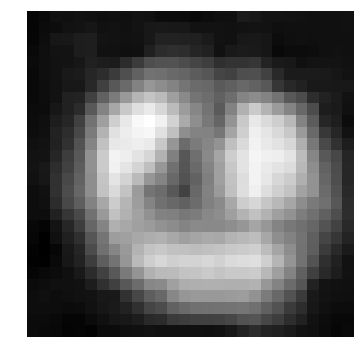

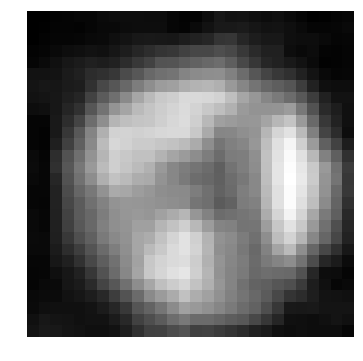

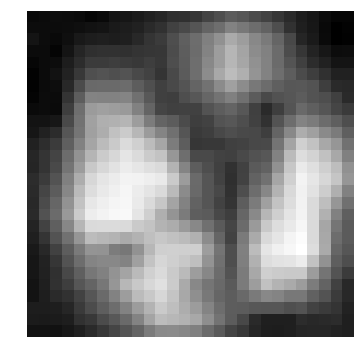

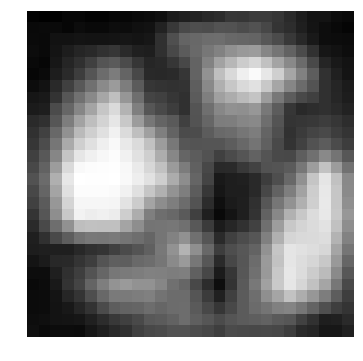

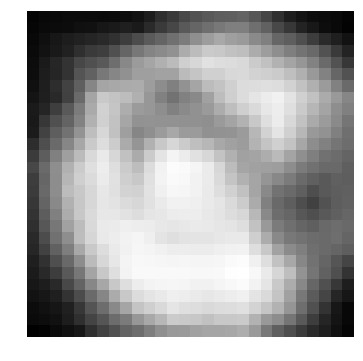

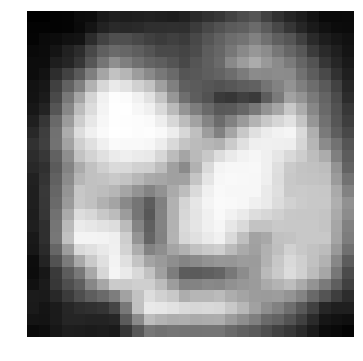

In [10]:
for i in range(2):
    view(class_images_dict['AA'][i])

for i in range(2):
    view(class_images_dict['KK'][i])
    
for i in range(2):
    view(class_images_dict['2'][i])

In [9]:
flat = class_images_dict['2'][0].tolist()
len(flat)

28

In [13]:
df = pd.DataFrame({'num': [1,2,3], 'tag': [class_images_dict['2'][0].flatten().tolist(), class_images_dict['2'][1].flatten().tolist(),class_images_dict['2'][2].flatten().tolist()]})
df

,num,tag
0,1,"[17, 16, 19, 22, 25, 25, 25, 28, 32, 36, 44, 5..."
1,2,"[19, 25, 28, 32, 35, 38, 45, 37, 33, 33, 32, 3..."
2,3,"[18, 19, 21, 22, 21, 21, 19, 21, 25, 32, 37, 4..."


(3, 28, 28)
(3, 28, 28, 1)


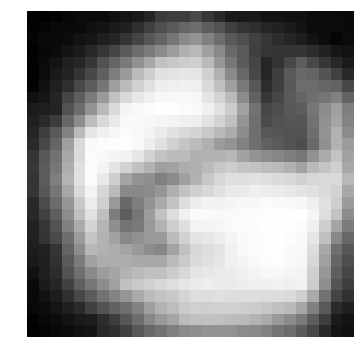

In [17]:
X = np.array([class_images_dict['2'][0], class_images_dict['2'][1], class_images_dict['2'][2]])
print(X.shape)
view(X[0])

tag_image_array_tf_shaped = X.reshape(X.shape[0], 28, 28, 1)
print(tag_image_array_tf_shaped.shape)

In [34]:
tags = np.array(list(df['tag']))
tags

array([[17, 16, 19, ..., 46, 32, 28],
       [19, 25, 28, ..., 44, 37, 30],
       [18, 19, 21, ..., 29, 29, 25]])

In [35]:
tags.shape

(3, 784)

In [36]:
tags = tags.reshape(tags.shape[0], 28, 28, 1)

In [38]:
tag1 = tags[0]
tag1.shape

(28, 28, 1)

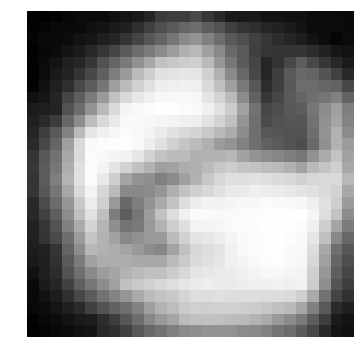

In [39]:
view(tags[0].reshape(1, 28, 28)[0])

In [11]:
def norm_image(image):
    image[image < 0] = 0
    image[image > 255] = 255
    return np.uint8(image)

def add_noise(image, n_or_u):
    noise = np.zeros((28,28), np.uint8)
    if n_or_u == 'n':
        cv2.randn(noise, 30, 2)
    else:
        cv2.randu(noise, 20, 2)
    noisy_image = np.uint32(image) + noise
    noisy_image[noisy_image < 0] = 0
    noisy_image[noisy_image > 255] = 255
    noisy_image = np.uint8(noisy_image)
    return noisy_image

def rotate_image(image):
    rotated_images = []
    for angle in range(90, 360, 90):
        M = cv2.getRotationMatrix2D((14,14),angle,1)
        r = cv2.warpAffine(image,M,(28,28))
        rotated_images.append(r)
    return rotated_images

def change_brightness_contrast(image):
    image_int32 = np.int32(image)
    increase_brightness = norm_image(image_int32 + 80)
    decrease_brightness = norm_image(image_int32 - 80)
    return [increase_brightness, decrease_brightness]
    
def occlude_edges(image):
    full_size = np.zeros((28, 28), dtype=np.uint8)
    full_size[2:26, 2:26] = image[2:26, 2:26]
    return full_size

def mean_smooth(image):
    mean_smoothed = cv2.blur(image, (3, 3))
    return mean_smoothed

def rotate_image_modifications(image):
    rotated_images = []
    for angle in range(90, 360, 90):
        M = cv2.getRotationMatrix2D((14,14),angle,1)
        r = cv2.warpAffine(image,M,(28,28))
        rotated_images.append(r)
    
    rotated_images[0] = add_noise(occlude_edges(rotated_images[0]), 'u')
    rotated_images[1] = norm_image(np.int32(rotated_images[1]) + 80)
    rotated_images[2] = norm_image(np.int32(rotated_images[2]) - 80)
    
    return rotated_images

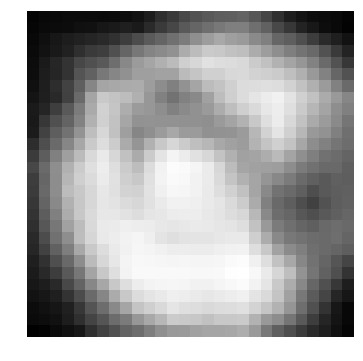

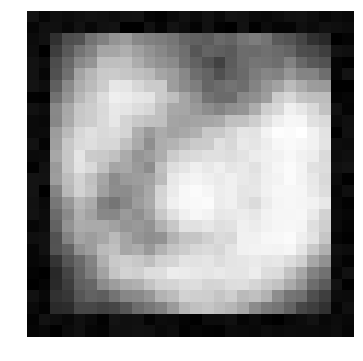

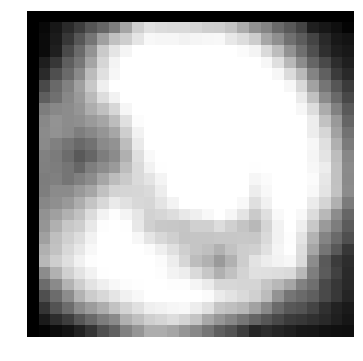

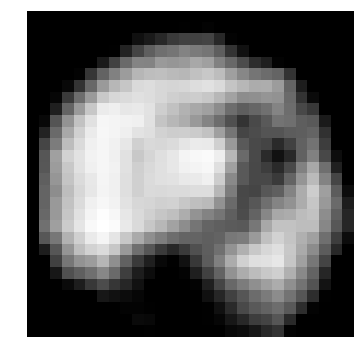

In [12]:
view(class_images_dict['2'][0])
for rot_im in rotate_image_modifications(class_images_dict['2'][0]):
    view(rot_im)

In [24]:
X = []
image_class_names_index = 0
image_class_names = {}
y = []

for tag_class in class_images_dict.keys():
    print(tag_class, len(class_images_dict[tag_class]))
    image_class_names[image_class_names_index] = tag_class
    for tag in class_images_dict[tag_class]:
        #generated_images = [tag]
        #generated_images.extend(change_brightness_contrast(tag))
        #generated_images.extend(rotate_image(tag))
        #generated_images.extend(rotate_image_modifications(tag))
        #X.extend(generated_images)
        X.append(tag)
        #X.append(tag)
        #y.extend([image_class_names_index] * len(generated_images))
        y.append(image_class_names_index)
    image_class_names_index += 1
    
X = np.array(X)
y = np.array(y)

('CircleLine', 21979)
('heart', 31483)
('Note1', 11372)
('DD', 18544)
('Note2', 5740)
('EE', 16548)
('Pillars', 46566)
('HH', 10322)
('Ampersand', 52180)
('Plant', 15522)
('leaf', 10602)
('arrowhollow', 12206)
('nn', 9380)
('Ankh', 24155)
('sun', 9234)
('TT', 5412)
('Trident', 38171)
('Asterisk', 26175)
('UU', 26626)
('1', 25417)
('0', 49403)
('3', 50449)
('2', 24018)
('5', 33364)
('4', 29191)
('7', 26233)
('6', 22919)
('8', 50096)
('Omega', 35036)
('CircleCross', 24111)
('AA', 8118)
('SS', 27285)
('Peace', 20233)
('hash', 12738)
('Tadpole', 18322)
('ArrowLine', 18905)
('Question', 11864)
('RR', 10427)
('PP', 28598)
('lines3', 14093)
('GG', 12529)
('y', 29240)
('XX', 48148)
('ZZ', 40500)
('radioactive', 56492)
('Triangle', 39294)
('Umbrella', 7119)
('Dot', 14171)
('a', 29950)
('e', 35868)
('Power', 36941)
('KK', 39608)
('h', 26713)
('Queen', 11149)
('Plane', 13622)
('MM', 37633)
('r', 21290)
('circlehalf', 21826)
('w', 25506)
('unknown', 30154)
('necklace', 15115)
('Scissors', 23398)


In [25]:
print(X.shape, y.shape)
print(set(y))
print(image_class_names[1])

((1549303, 28, 28), (1549303,))
set([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61])
heart


In [26]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=4)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

((1239442, 28, 28), (1239442,), (309861, 28, 28), (309861,))


In [27]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from keras import backend as K

In [28]:
Y_train = np_utils.to_categorical(y_train, len(set(y_train)))
Y_test = np_utils.to_categorical(y_test, len(set(y_train)))

In [29]:
img_rows = 28
img_cols = 28

if K.image_dim_ordering() == 'th':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)

X_train.shape

(1239442, 28, 28, 1)

In [30]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

In [31]:
del X
del y

In [32]:
model = Sequential()
# input layer
#model.add(Convolution2D(32, (3, 3), activation='relu', input_shape=(1,28,28))) # if theano backend
model.add(Convolution2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))

model.add(Convolution2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(62, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [33]:
model.fit(X_train, Y_train, batch_size=32, epochs=10, verbose=1)

Epoch 1/10
1239442/1239442 [==============================] - 1304s - loss: 1.3780 - acc: 0.5986  
Epoch 2/10
1239442/1239442 [==============================] - 1304s - loss: 0.9841 - acc: 0.7116  
Epoch 3/10
1239442/1239442 [==============================] - 1307s - loss: 0.8825 - acc: 0.7438  
Epoch 4/10
1239442/1239442 [==============================] - 1315s - loss: 0.8403 - acc: 0.7565  
Epoch 5/10
1239442/1239442 [==============================] - 1316s - loss: 0.8150 - acc: 0.7640  
Epoch 6/10
1239442/1239442 [==============================] - 1344s - loss: 0.7980 - acc: 0.7696  
Epoch 7/10
1239442/1239442 [==============================] - 1367s - loss: 0.7881 - acc: 0.7732  
Epoch 8/10
1239442/1239442 [==============================] - 1372s - loss: 0.7800 - acc: 0.7755  
Epoch 9/10
1239442/1239442 [==============================] - 1354s - loss: 0.7720 - acc: 0.7784  
Epoch 10/10
1239442/1239442 [==============================] - 1357s - loss: 0.7593 - acc: 0.7823  


In [34]:
model.save('model.h5')

In [35]:
print(image_class_names)

{0: 'CircleLine', 1: 'heart', 2: 'Note1', 3: 'DD', 4: 'Note2', 5: 'EE', 6: 'Pillars', 7: 'HH', 8: 'Ampersand', 9: 'Plant', 10: 'leaf', 11: 'arrowhollow', 12: 'nn', 13: 'Ankh', 14: 'sun', 15: 'TT', 16: 'Trident', 17: 'Asterisk', 18: 'UU', 19: '1', 20: '0', 21: '3', 22: '2', 23: '5', 24: '4', 25: '7', 26: '6', 27: '8', 28: 'Omega', 29: 'CircleCross', 30: 'AA', 31: 'SS', 32: 'Peace', 33: 'hash', 34: 'Tadpole', 35: 'ArrowLine', 36: 'Question', 37: 'RR', 38: 'PP', 39: 'lines3', 40: 'GG', 41: 'y', 42: 'XX', 43: 'ZZ', 44: 'radioactive', 45: 'Triangle', 46: 'Umbrella', 47: 'Dot', 48: 'a', 49: 'e', 50: 'Power', 51: 'KK', 52: 'h', 53: 'Queen', 54: 'Plane', 55: 'MM', 56: 'r', 57: 'circlehalf', 58: 'w', 59: 'unknown', 60: 'necklace', 61: 'Scissors'}


In [36]:
pc = model.predict_classes(X_test)
pc

309856/309861 [============================>.] - ETA: 0s

array([44, 23, 27, ..., 42, 17, 28])

In [37]:
score = model.evaluate(X_test, Y_test) #, verbose=0
score

309728/309861 [============================>.] - ETA: 0s

[0.34420451329460677, 0.91488764316903382]

In [23]:
pc

array([26, 52, 55, ..., 55, 23, 42])

In [25]:
Y_test[0]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

'0'

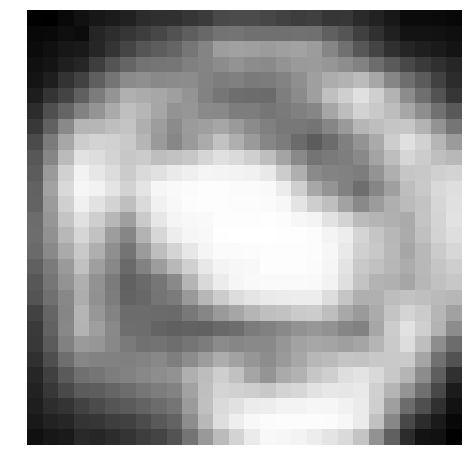

In [55]:
view(X_test[6].reshape(1, 28, 28)[0])
image_class_names[pc[6]]

In [56]:
image_class_names

{0: 'CircleLine',
 1: 'heart',
 2: 'Note1',
 3: 'DD',
 4: 'Note2',
 5: 'EE',
 6: 'Pillars',
 7: 'HH',
 8: 'Ampersand',
 9: 'Plant',
 10: 'leaf',
 11: 'arrowhollow',
 12: 'nn',
 13: 'Ankh',
 14: 'sun',
 15: 'TT',
 16: 'Trident',
 17: 'Asterisk',
 18: 'UU',
 19: '1',
 20: '0',
 21: '3',
 22: '2',
 23: '5',
 24: '4',
 25: '7',
 26: '6',
 27: '8',
 28: 'Omega',
 29: 'CircleCross',
 30: 'AA',
 31: 'SS',
 32: 'Peace',
 33: 'hash',
 34: 'Tadpole',
 35: 'ArrowLine',
 36: 'Question',
 37: 'RR',
 38: 'PP',
 39: 'lines3',
 40: 'GG',
 41: 'y',
 42: 'XX',
 43: 'ZZ',
 44: 'radioactive',
 45: 'Triangle',
 46: 'Umbrella',
 47: 'Dot',
 48: 'a',
 49: 'e',
 50: 'Power',
 51: 'KK',
 52: 'h',
 53: 'Queen',
 54: 'Plane',
 55: 'MM',
 56: 'r',
 57: 'circlehalf',
 58: 'w',
 59: 'unknown',
 60: 'necklace',
 61: 'Scissors'}

In [20]:
from sklearn.metrics import confusion_matrix

In [69]:
cm = confusion_matrix(y_test, pc, labels=None, sample_weight=None)

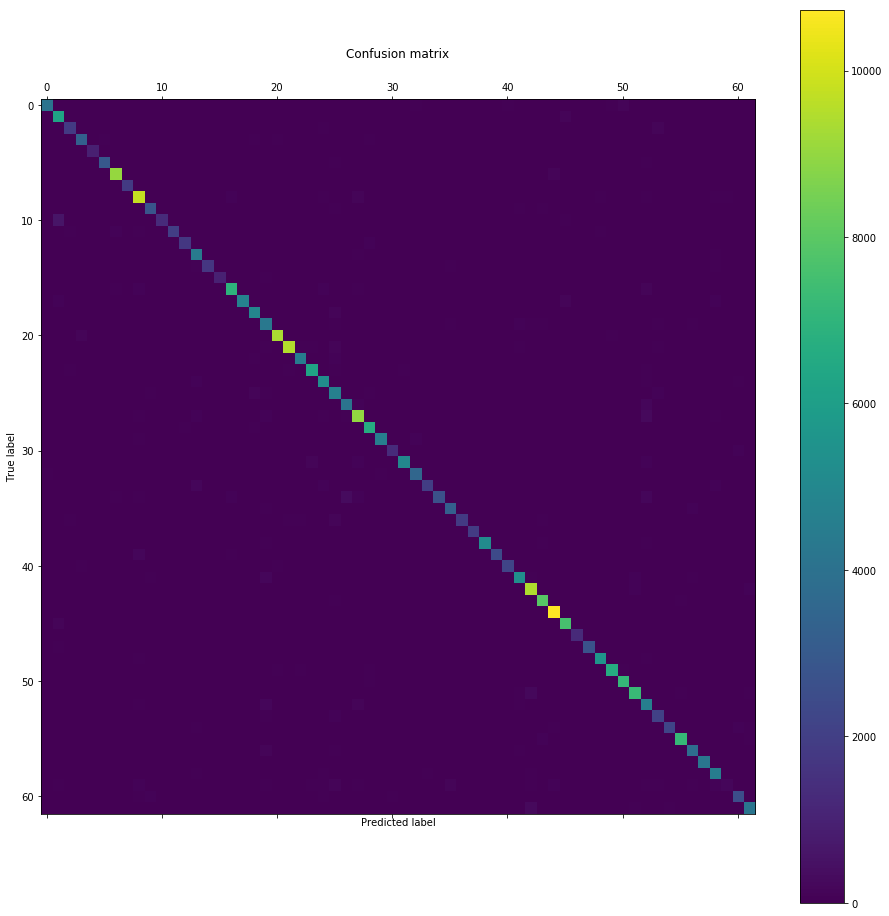

In [70]:
plt.matshow(cm)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()